In [1]:
# Chosen using results from Bipolar-K
epsilon = 0.75
k = 250

input_dim = 13166
num_clusters = 18

model_file = "/home/gregory/Desktop/ELDR/Bipolar/Model/model/perplexity_10_regularizer_0.001_batch_size_512_learning_rate_0.01_latent_dimension_2_activation_ELU_seed_1_iter_5400.ckpt"
pc_matrix_file = "/home/gregory/Desktop/ELDR/Bipolar/Data/bipolar_pc.tsv"

import csv
import json
import matplotlib
import numpy as np
import os
import pandas as pd

os.system("rm *.png")

from load_vae import load_vae

import sys
sys.path.insert(0, "../Code/")
from explain_cs import explain
from metrics import metrics, eval_epsilon
from myplot import plot_polys, plot_groups, plot_metrics, plot_explanation
from misc import poly2labels

matplotlib.rc("lines", markersize = 4)# Override some default plot parameters

def load_model(input_dim = input_dim, model_file = model_file):
    return load_vae(input_dim, model_file, feature_transform = pc_matrix_file)


The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



In [2]:
# Load Data & Configuration

x = pd.read_csv("Data/bipolar_rep_scaled.tsv", sep="\t").values

with open("vertices.json") as json_file:  
    all_vertices = json.load(json_file)


In [3]:
# Approximate the original data

matrix = pd.read_csv(pc_matrix_file, sep = "\t", header = None).values

x_full = np.matmul(x, np.transpose(matrix))

In [4]:
# Calculate Data Representation

sess, rep, X, D = load_model()

data_rep = sess.run(rep, feed_dict={X: x_full, D: np.zeros((1, input_dim))})




Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.



INFO:tensorflow:Restoring parameters from /home/gregory/Desktop/ELDR/Bipolar/Model/model/perplexity_10_regularizer_0.001_batch_size_512_learning_rate_0.01_latent_dimension_2_activation_ELU_seed_1_iter_5400.ckpt


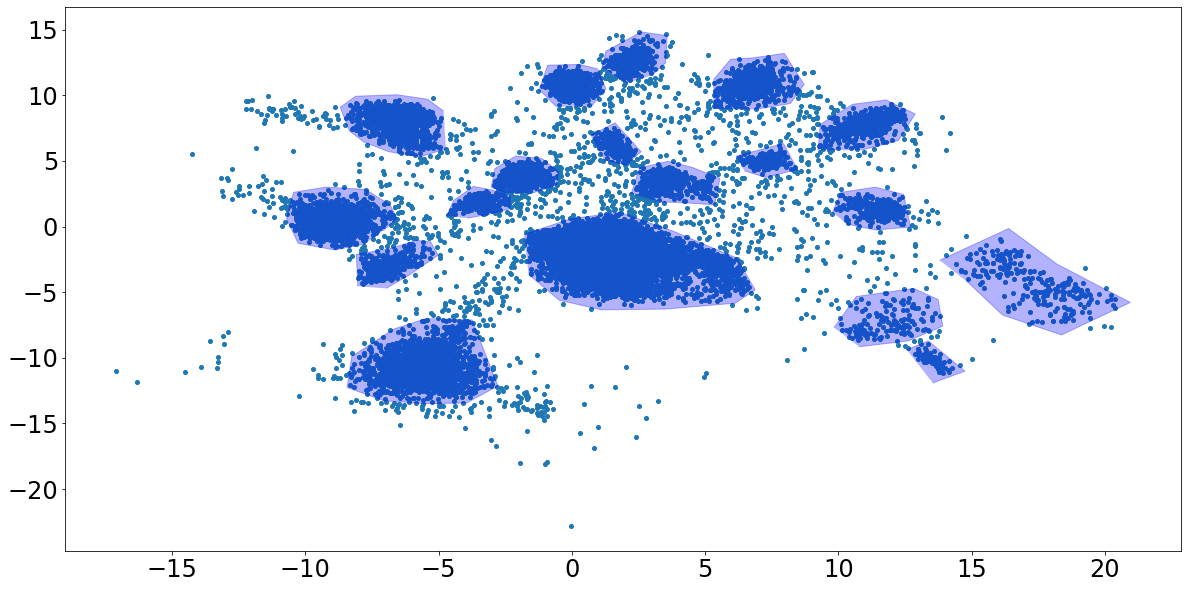

In [5]:
# Visualize the data and the marked clusters
plot_polys(data_rep, all_vertices)

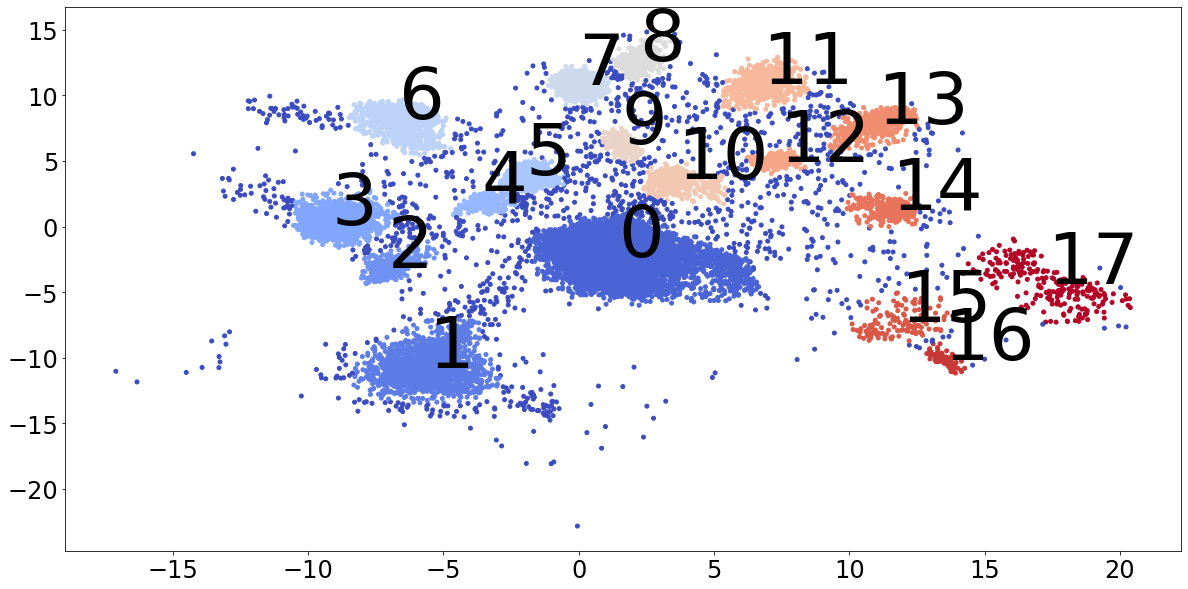

In [6]:
# Visualize the clusters in the learned representation

labels = poly2labels(data_rep, all_vertices)

means, centers, indices = plot_groups(x_full, data_rep, num_clusters, labels, name = "bipolar-rep.png")


INFO:tensorflow:Restoring parameters from /home/gregory/Desktop/ELDR/Bipolar/Model/model/perplexity_10_regularizer_0.001_batch_size_512_learning_rate_0.01_latent_dimension_2_activation_ELU_seed_1_iter_5400.ckpt


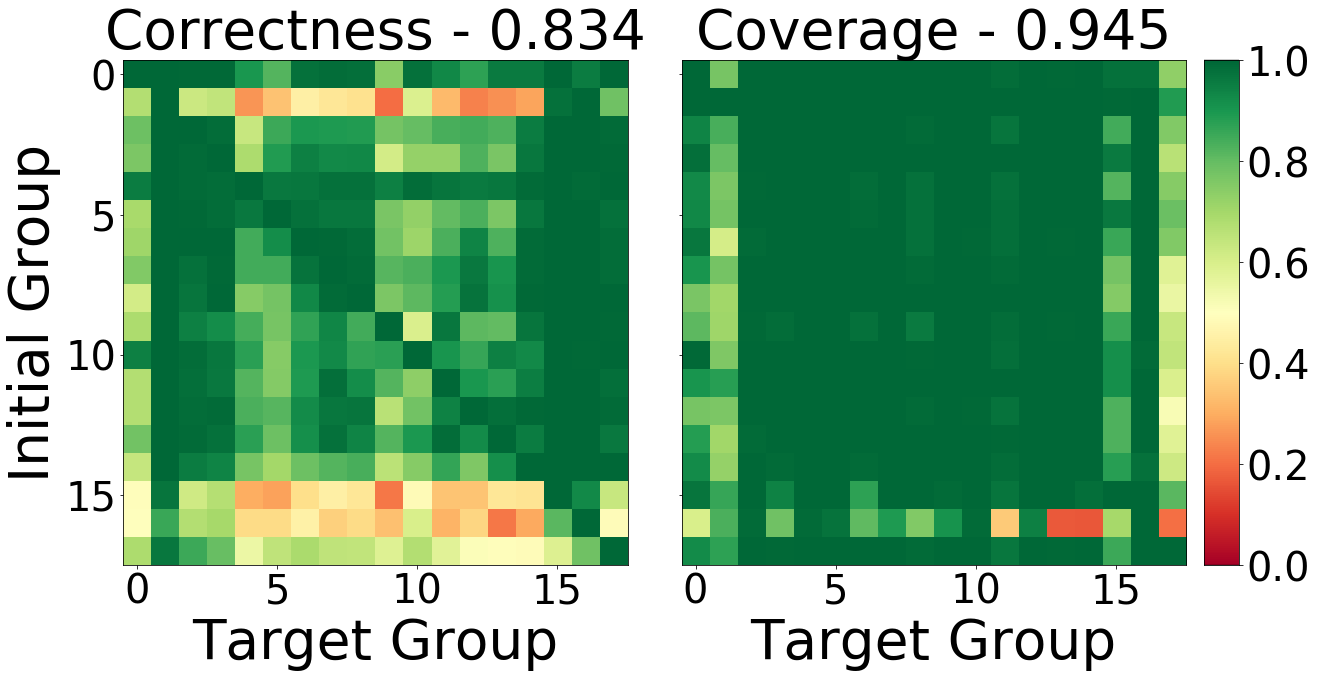

INFO:tensorflow:Restoring parameters from /home/gregory/Desktop/ELDR/Bipolar/Model/model/perplexity_10_regularizer_0.001_batch_size_512_learning_rate_0.01_latent_dimension_2_activation_ELU_seed_1_iter_5400.ckpt
INFO:tensorflow:Restoring parameters from /home/gregory/Desktop/ELDR/Bipolar/Model/model/perplexity_10_regularizer_0.001_batch_size_512_learning_rate_0.01_latent_dimension_2_activation_ELU_seed_1_iter_5400.ckpt


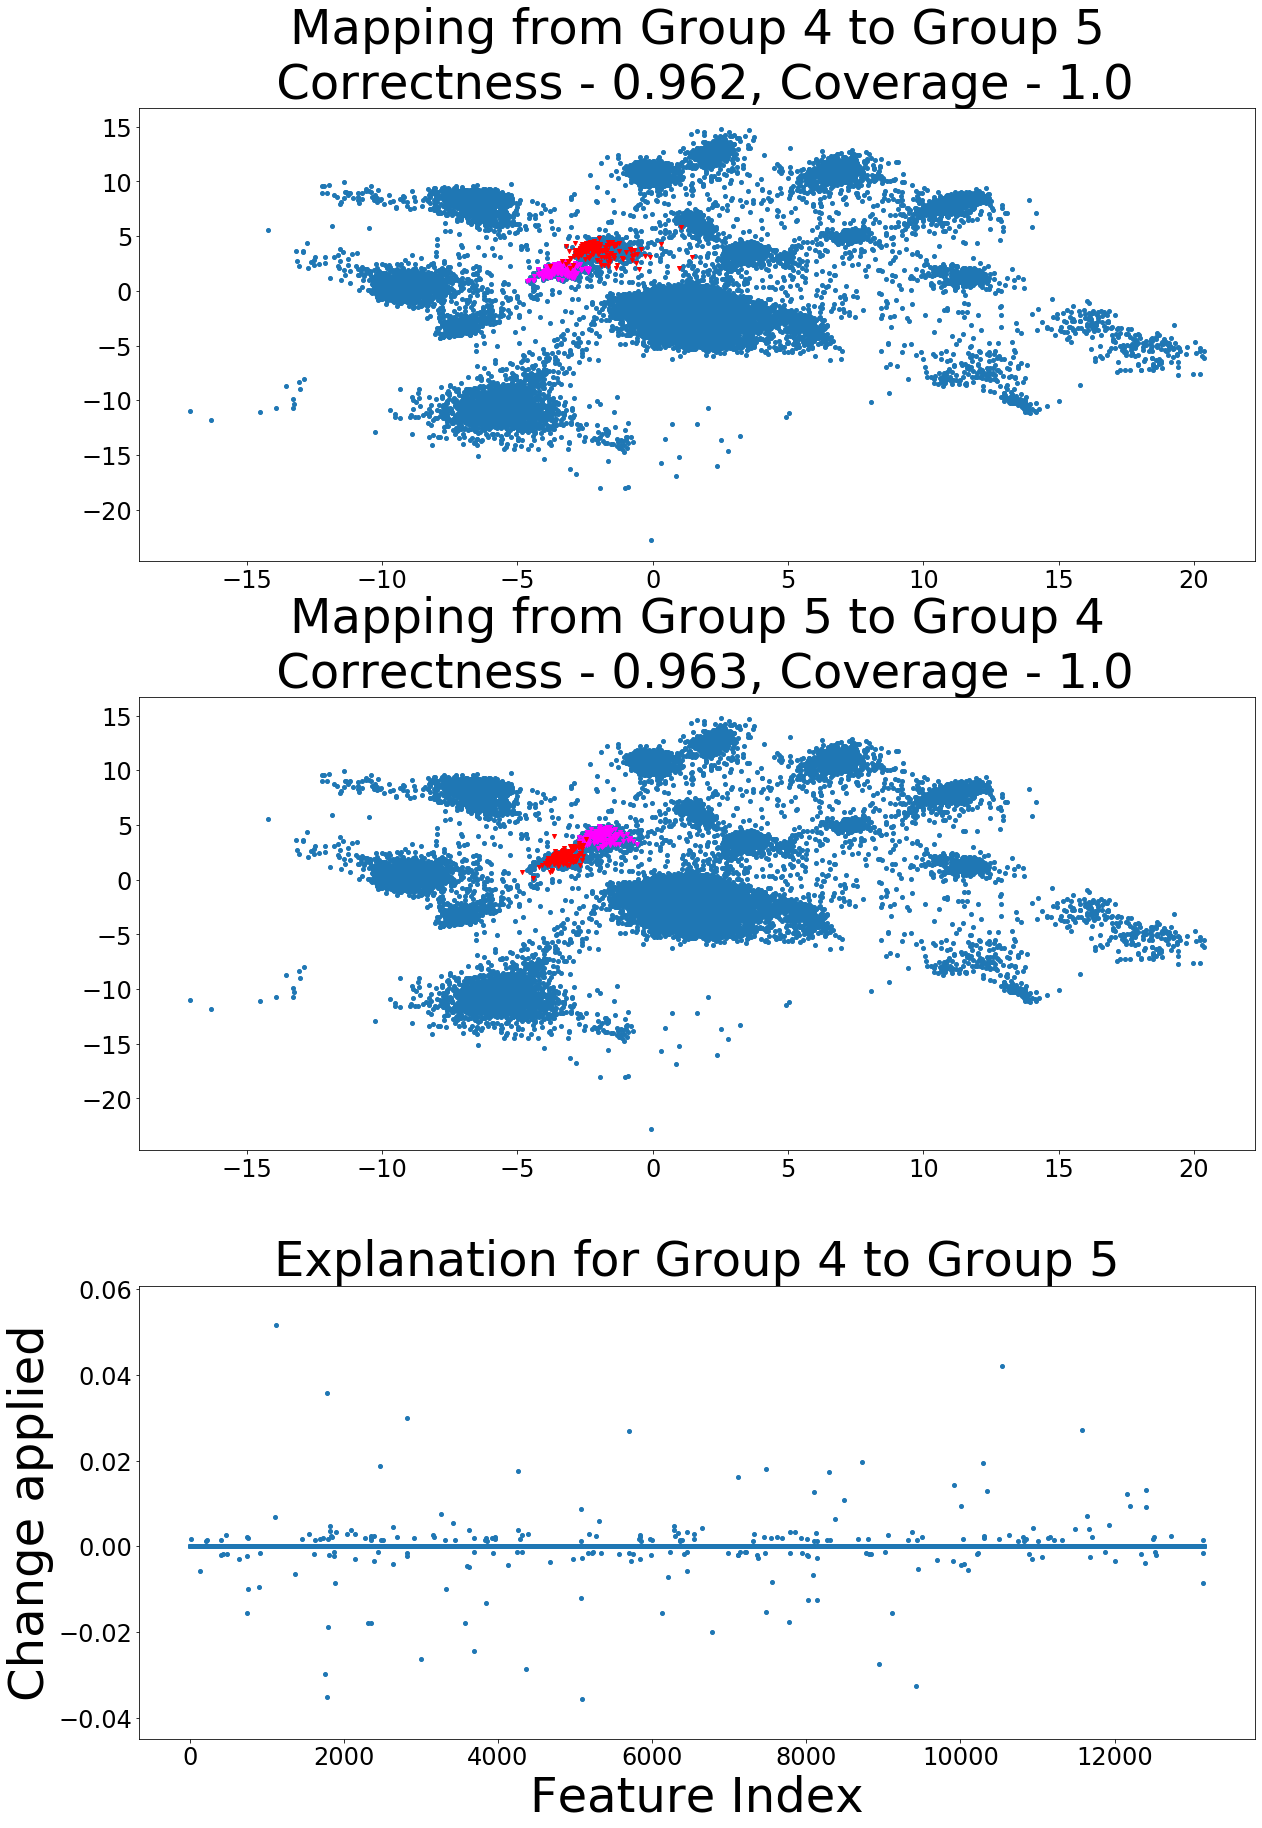

INFO:tensorflow:Restoring parameters from /home/gregory/Desktop/ELDR/Bipolar/Model/model/perplexity_10_regularizer_0.001_batch_size_512_learning_rate_0.01_latent_dimension_2_activation_ELU_seed_1_iter_5400.ckpt
INFO:tensorflow:Restoring parameters from /home/gregory/Desktop/ELDR/Bipolar/Model/model/perplexity_10_regularizer_0.001_batch_size_512_learning_rate_0.01_latent_dimension_2_activation_ELU_seed_1_iter_5400.ckpt


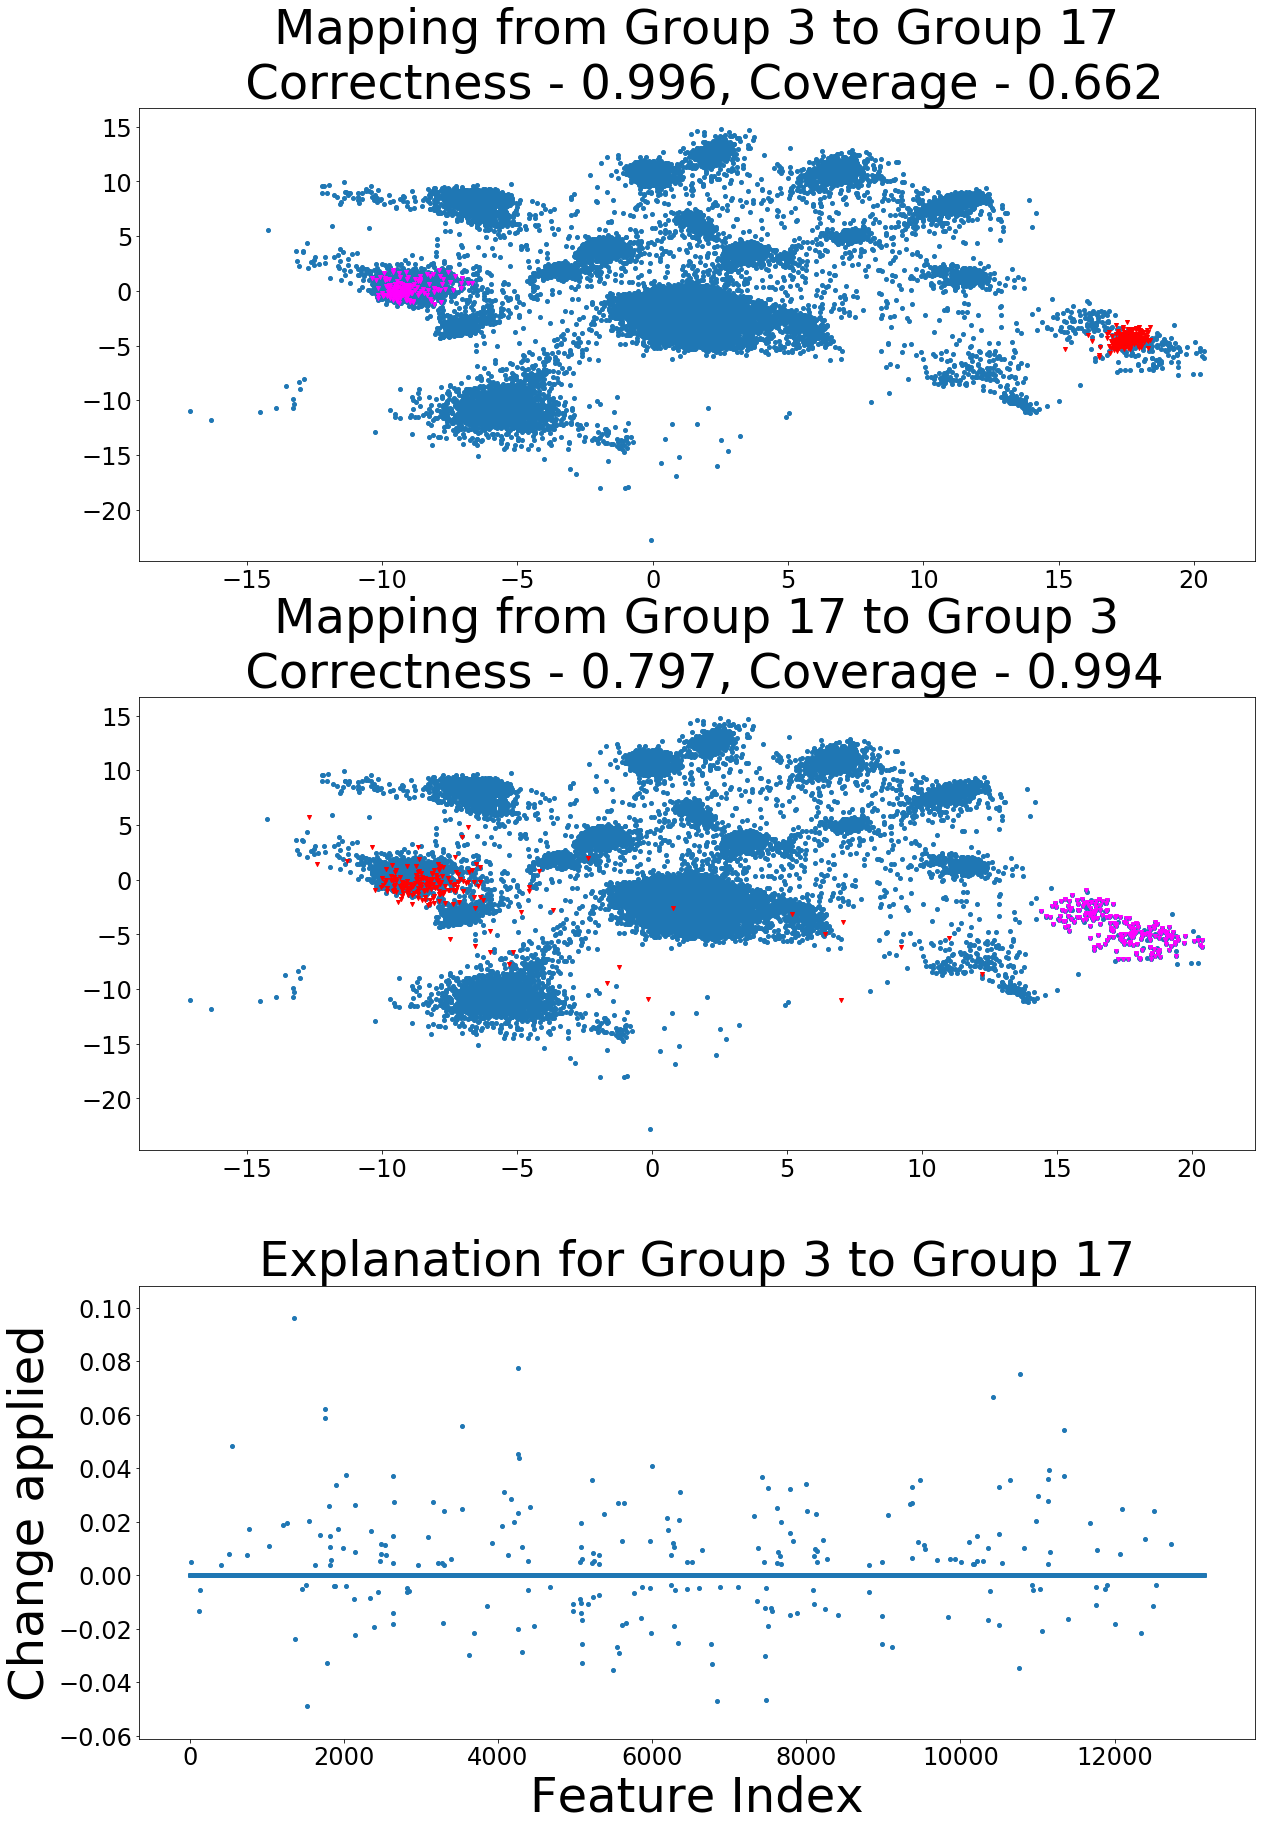

INFO:tensorflow:Restoring parameters from /home/gregory/Desktop/ELDR/Bipolar/Model/model/perplexity_10_regularizer_0.001_batch_size_512_learning_rate_0.01_latent_dimension_2_activation_ELU_seed_1_iter_5400.ckpt
INFO:tensorflow:Restoring parameters from /home/gregory/Desktop/ELDR/Bipolar/Model/model/perplexity_10_regularizer_0.001_batch_size_512_learning_rate_0.01_latent_dimension_2_activation_ELU_seed_1_iter_5400.ckpt


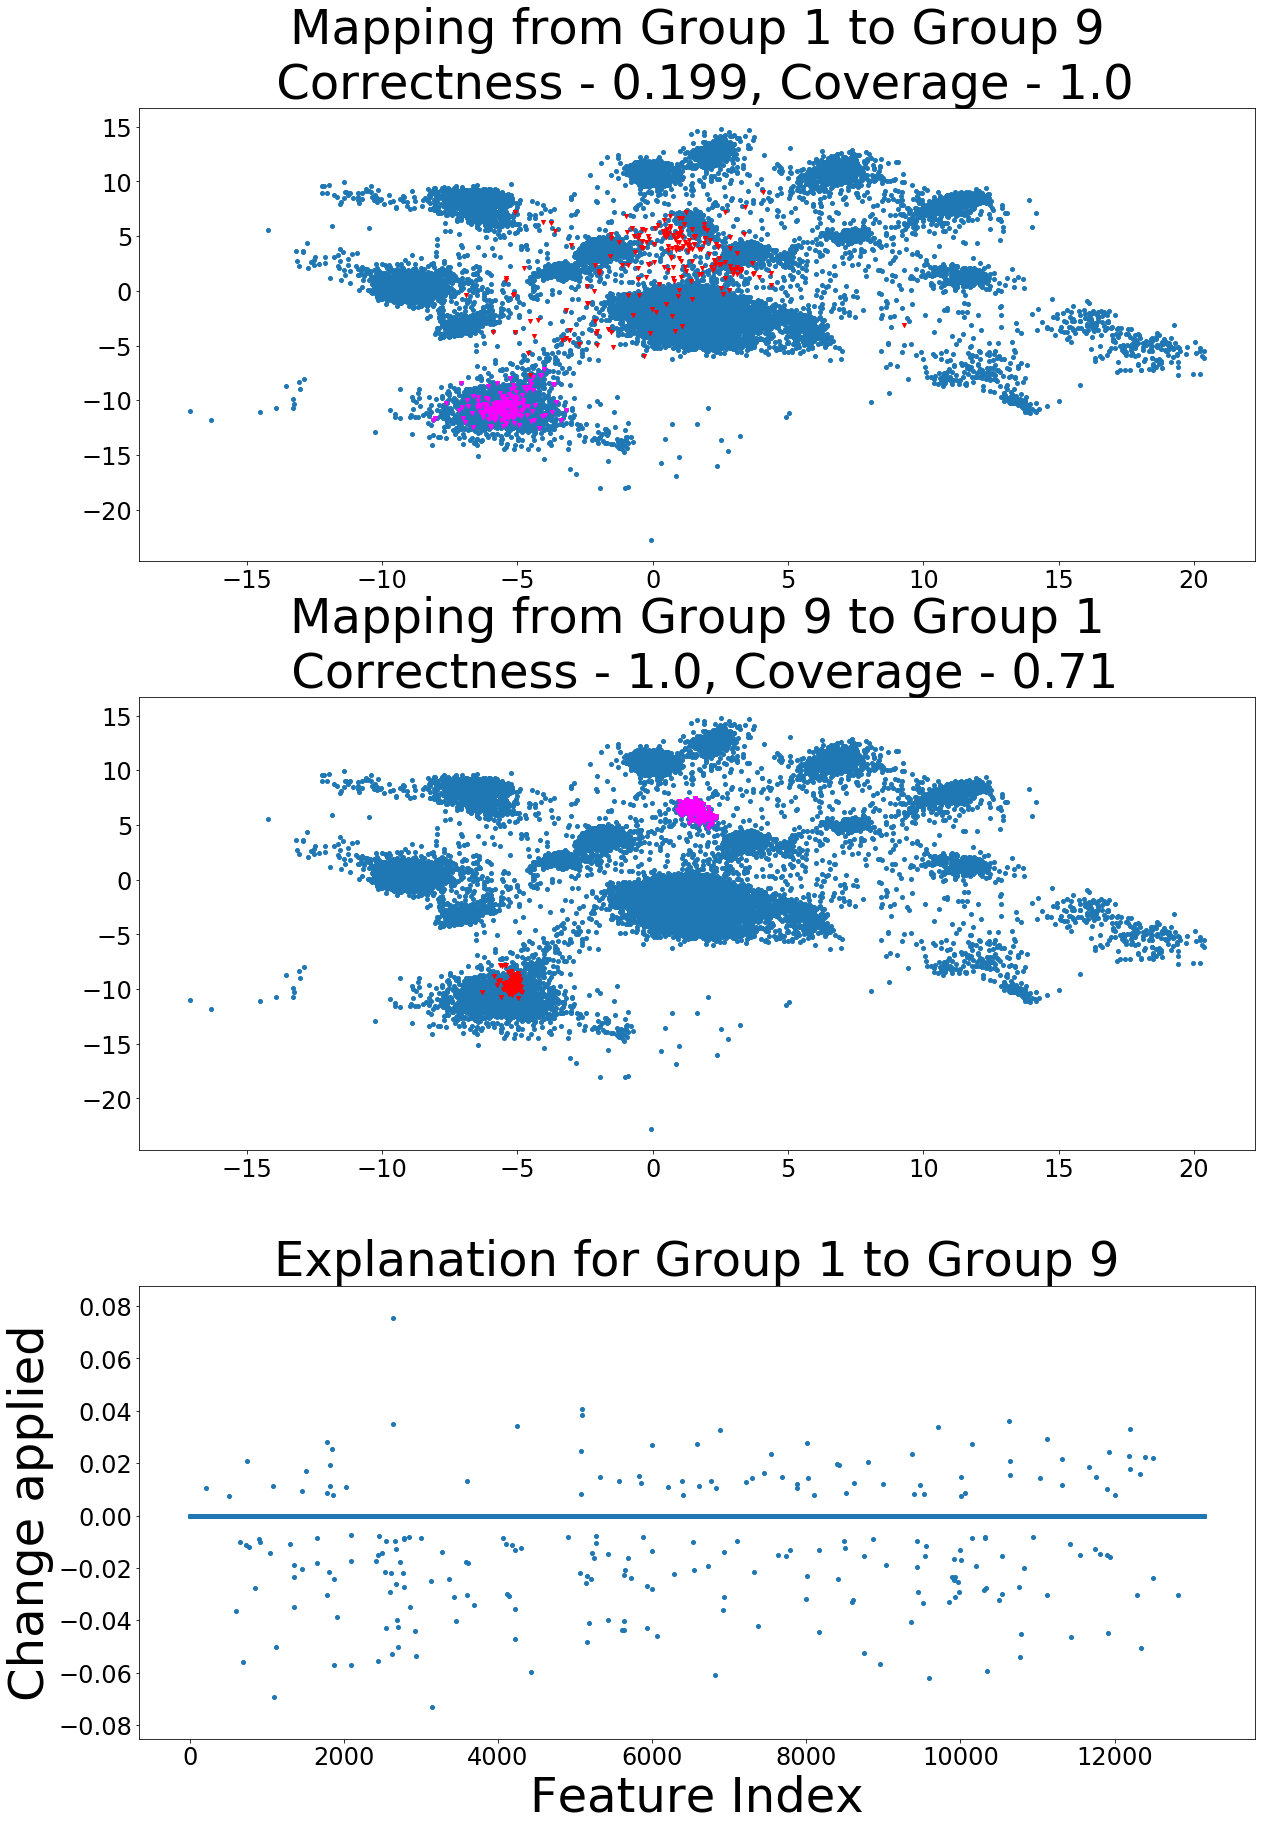

In [7]:
# Evaluate our explanations

deltas = np.load("../Bipolar-K/deltas" + str(k) + ".npy")

a, b = metrics(load_model, x_full, indices, deltas, epsilon, k = k)

plot_metrics(a, b, "bipolar-metrics.png")

plot_explanation(load_model, x_full, data_rep, indices, deltas, a, b, 4, 5, k = k, name = "bipolar-close.png", num_points = 200)

plot_explanation(load_model, x_full, data_rep, indices, deltas, a, b, 3, 17, k = k, name = "bipolar-far.png", num_points = 200)

plot_explanation(load_model, x_full, data_rep, indices, deltas, a, b, 1, 9, k = k, name = "bipolar-hard.png", num_points = 200)


INFO:tensorflow:Restoring parameters from /home/gregory/Desktop/ELDR/Bipolar/Model/model/perplexity_10_regularizer_0.001_batch_size_512_learning_rate_0.01_latent_dimension_2_activation_ELU_seed_1_iter_5400.ckpt


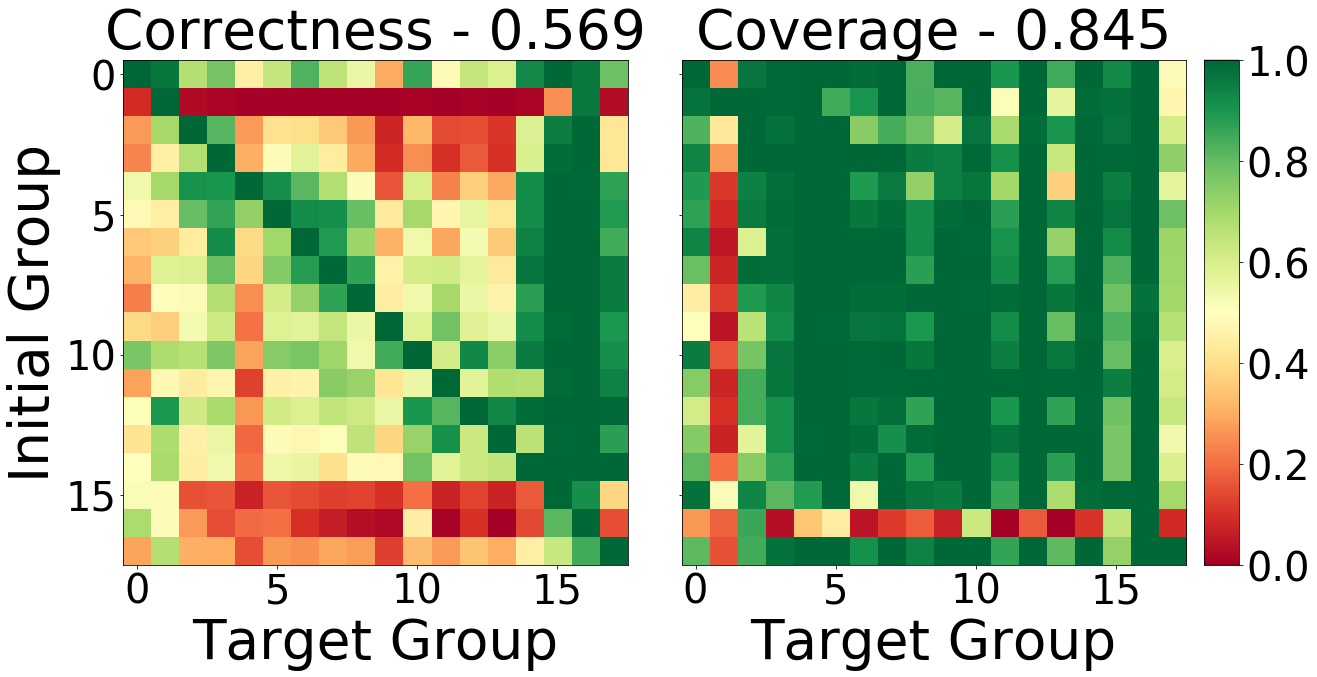

INFO:tensorflow:Restoring parameters from /home/gregory/Desktop/ELDR/Bipolar/Model/model/perplexity_10_regularizer_0.001_batch_size_512_learning_rate_0.01_latent_dimension_2_activation_ELU_seed_1_iter_5400.ckpt
INFO:tensorflow:Restoring parameters from /home/gregory/Desktop/ELDR/Bipolar/Model/model/perplexity_10_regularizer_0.001_batch_size_512_learning_rate_0.01_latent_dimension_2_activation_ELU_seed_1_iter_5400.ckpt


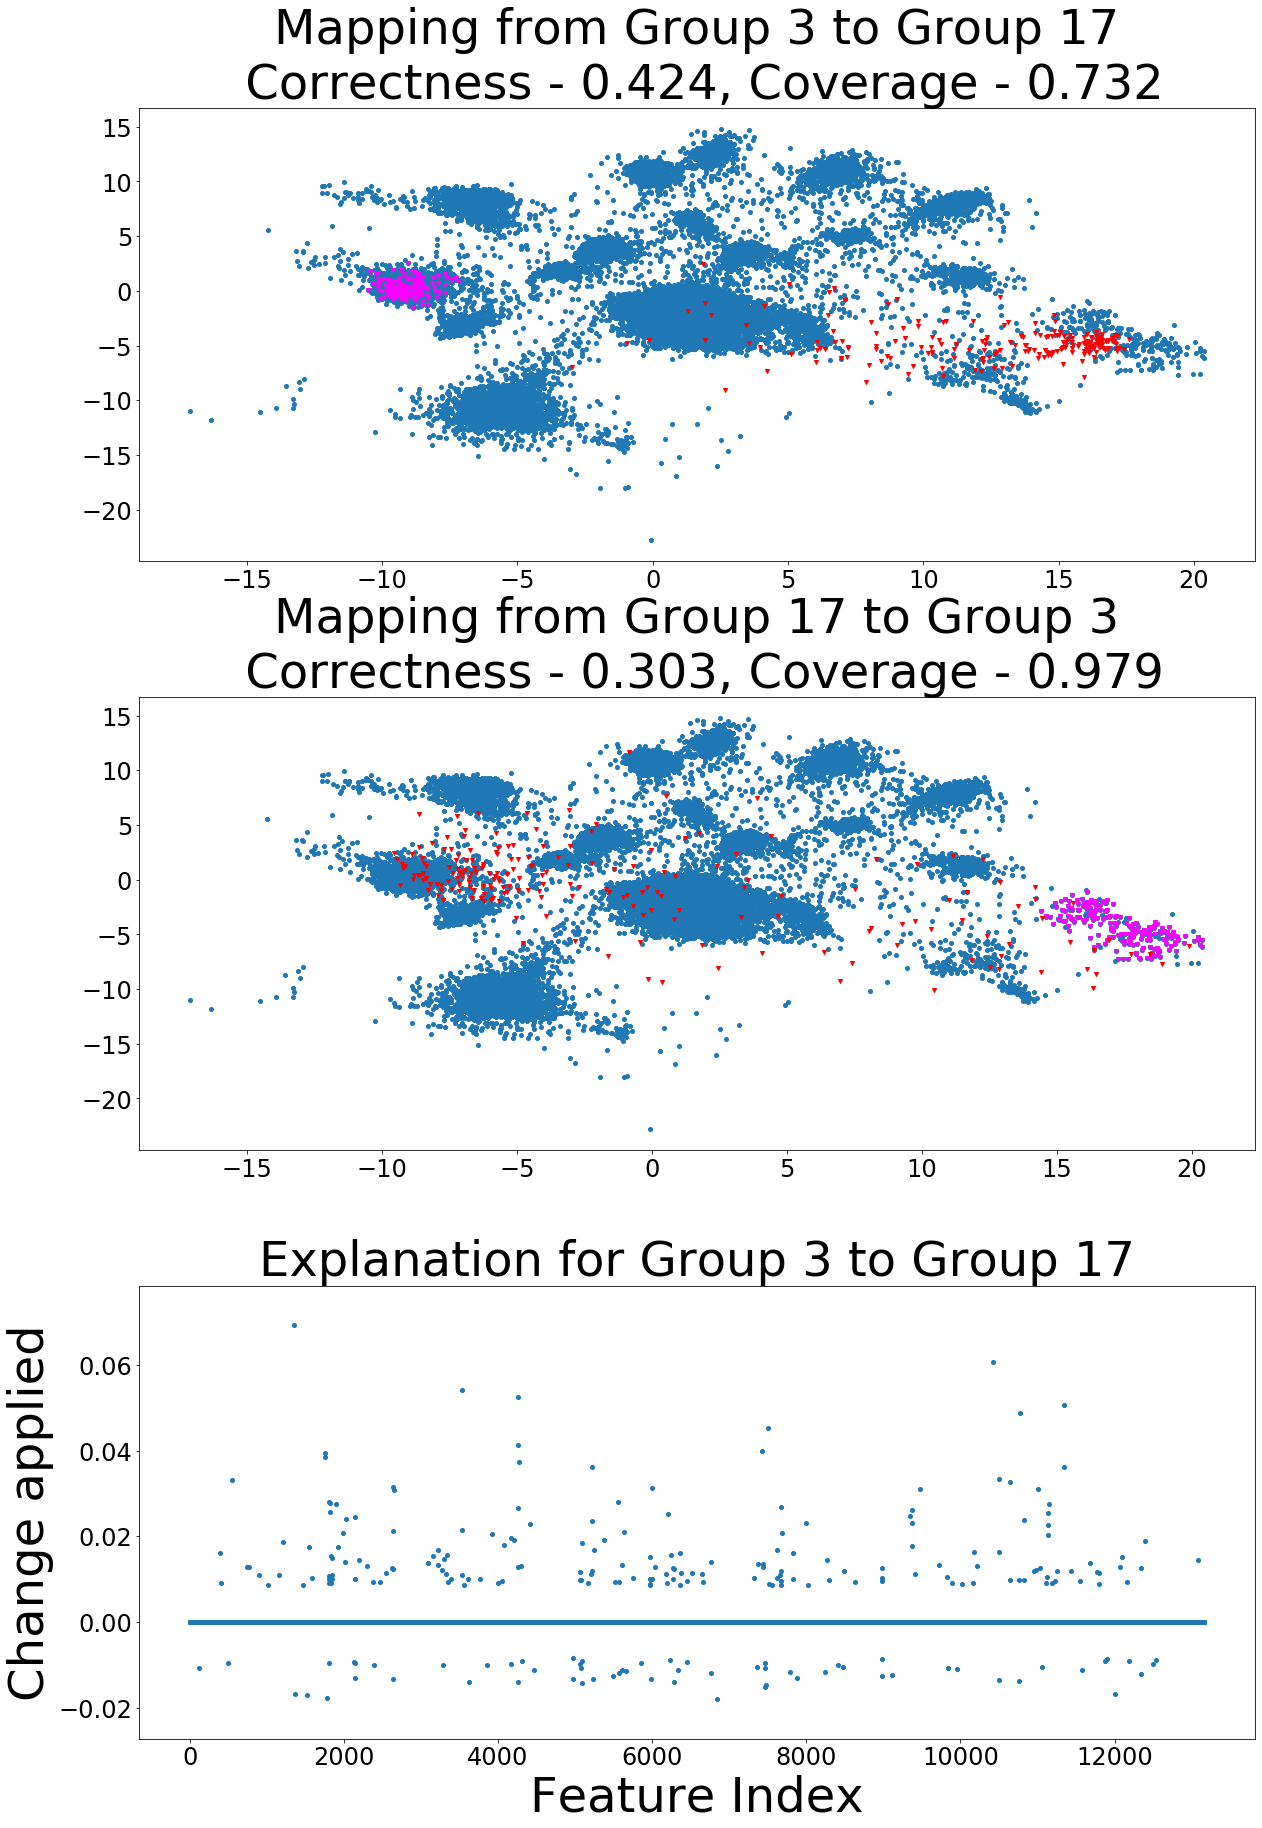

In [8]:
# Evaluate Truncated DBM 

exp_mean = np.zeros((num_clusters - 1, input_dim))
for i in range(num_clusters - 1):
    exp_mean[i, :] = means[i + 1] - means[0]
    
a, b = metrics(load_model, x_full, indices, exp_mean, epsilon, k = k)

plot_metrics(a, b, name = "bipolar-metrics-means.png")

plot_explanation(load_model, x_full, data_rep, indices, exp_mean, a, b, 3, 17, k = k, name = "bipolar-far-means-k.png", num_points = 200)



INFO:tensorflow:Restoring parameters from /home/gregory/Desktop/ELDR/Bipolar/Model/model/perplexity_10_regularizer_0.001_batch_size_512_learning_rate_0.01_latent_dimension_2_activation_ELU_seed_1_iter_5400.ckpt
INFO:tensorflow:Restoring parameters from /home/gregory/Desktop/ELDR/Bipolar/Model/model/perplexity_10_regularizer_0.001_batch_size_512_learning_rate_0.01_latent_dimension_2_activation_ELU_seed_1_iter_5400.ckpt
INFO:tensorflow:Restoring parameters from /home/gregory/Desktop/ELDR/Bipolar/Model/model/perplexity_10_regularizer_0.001_batch_size_512_learning_rate_0.01_latent_dimension_2_activation_ELU_seed_1_iter_5400.ckpt


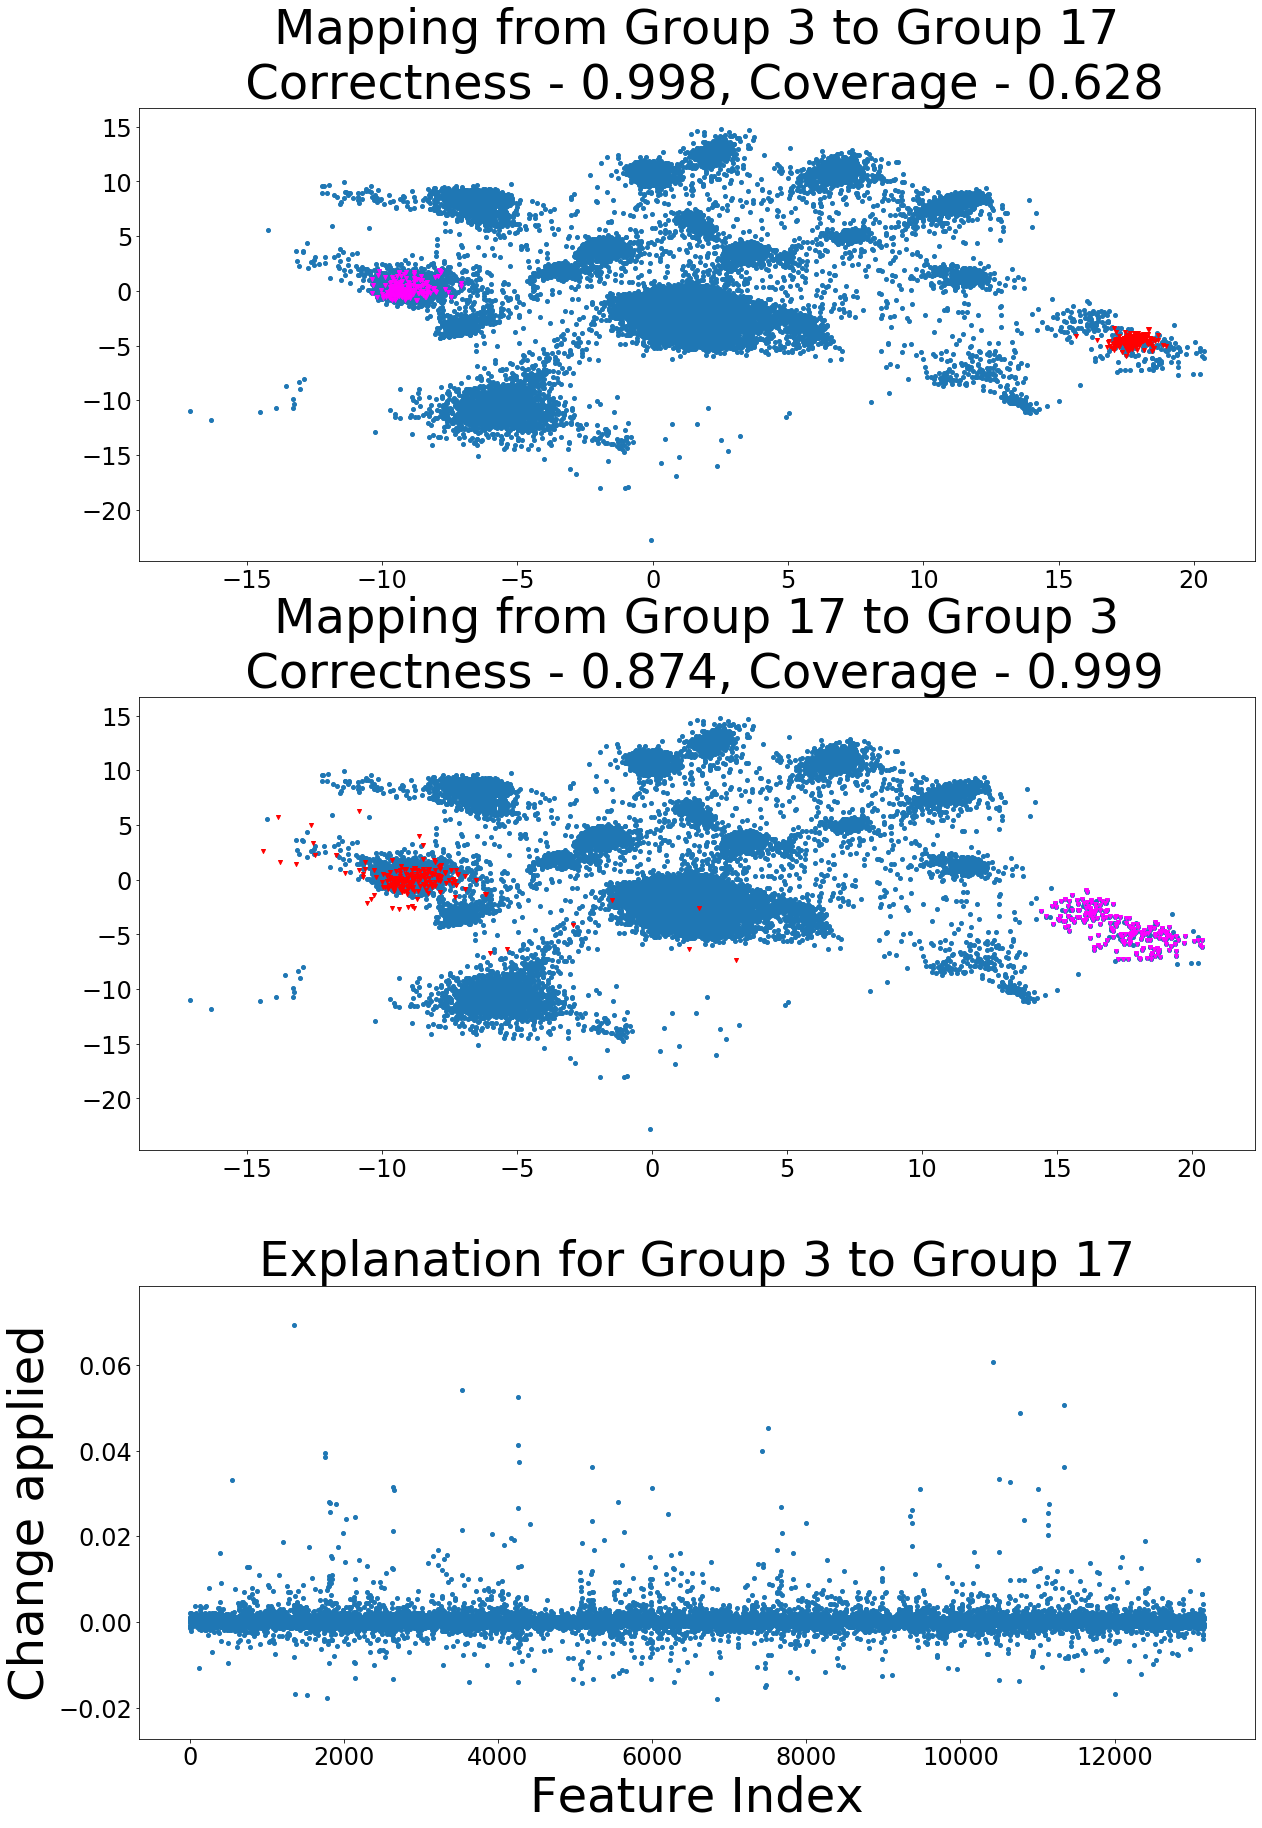

In [9]:
# Evaluate DBM
a, b = metrics(load_model, x_full, indices, exp_mean, epsilon)

plot_explanation(load_model, x_full, data_rep, indices, exp_mean, a, b, 3, 17, name = "bipolar-far-means.png", num_points = 200)
